In [68]:
import sys

# resolve path for notebook
sys.path.append('../')

In [69]:
import gym
import math
import torch
import pyglet
import random
import minihack

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from nle import nethack
from collections import deque

from torch.autograd import Variable
from torch.distributions import Categorical


from environments.QuestEnvironment import QuestEnvironment

In [70]:
# if there is a Cuda GPU, then we want to use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [71]:
num_episodes = 1000
max_steps = 5000
alpha = 0.001
alpha = 0.00001
gamma = 0.9999
epsilon = 1e-12
epsilon = 1e-1
OBS_SPACE = 'glyphs_crop'
#OBS_SPACE = 'blstats'
seed = 99
verbose = False
intermediate_plots = True

In [72]:
env = QuestEnvironment().create(
    reward_lose = -100,
    reward_win = 100,
    penalty_step = -0.01,
    penalty_time = 0,
    max_episode_steps = max_steps,
    seed = seed
)

In [73]:
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
env.seed(seed)

(99, 650139921597015349, False)

In [74]:
class PolicyValueNetwork:

    def __init__(self, env, alpha):

        if len(env.observation_space.spaces[OBS_SPACE].shape) == 1:
            self.obs_space = env.observation_space.spaces[OBS_SPACE].shape[0]
        else:
            self.obs_space = env.observation_space.spaces[OBS_SPACE].shape[0] * \
                        env.observation_space.spaces[OBS_SPACE].shape[1]

        self.policy_net = torch.nn.Sequential(
            torch.nn.Linear(self.obs_space, self.obs_space*2),
            torch.nn.ReLU(),

            # hidden layers
            torch.nn.Linear(self.obs_space*2, self.obs_space*2),
            torch.nn.ReLU(),

            torch.nn.Linear(self.obs_space*2, env.action_space.n),
            torch.nn.Softmax(dim = -1)
        )

        self.policy_optimizer = torch.optim.Adam(self.policy_net.parameters(), lr = alpha)

        self.value_net = torch.nn.Sequential(
            torch.nn.Linear(self.obs_space, self.obs_space*2),
            torch.nn.ReLU(),

            # hidden layers
            torch.nn.Linear(self.obs_space*2, self.obs_space*2),
            torch.nn.ReLU(),

            torch.nn.Linear(self.obs_space*2, self.obs_space),
            torch.nn.ReLU(),
            torch.nn.Linear(self.obs_space, 1)
        )

        self.value_optimizer = torch.optim.Adam(self.value_net.parameters(), lr = alpha)


nn = PolicyValueNetwork(env, alpha)

In [75]:
# if len(env.observation_space.spaces[OBS_SPACE].shape) == 1:
#     obs_space = env.observation_space.spaces[OBS_SPACE].shape[0]
# else:
#     obs_space = env.observation_space.spaces[OBS_SPACE].shape[0] * \
#                 env.observation_space.spaces[OBS_SPACE].shape[1]

# nn = torch.nn.Sequential(
#     torch.nn.Linear(obs_space, obs_space*2),
#     torch.nn.ReLU(),

#     # hidden layers
#     #torch.nn.Linear(obs_space*2, obs_space*2),
#     #torch.nn.ReLU(),
#     # torch.nn.Linear(obs_space*3, obs_space*2),
#     # torch.nn.ReLU(),

#     torch.nn.Linear(obs_space*2, env.action_space.n),
#     torch.nn.Softmax(dim = -1)
# )
# optim = torch.optim.Adam(nn.parameters(), lr=alpha)

In [76]:
visit_counts = dict()
coord_rewards = dict()

def get_exploration_reward(state, reward):
    s = state['blstats']

    #return reward
    coords = (int(s[0]), int(s[1]))

    if coords not in visit_counts:
        visit_counts[coords] = 1
        #return 0.001
        coord_rewards[coords] = reward
    else:
        #return 0
        visit_counts[coords] += 1
        coord_rewards[coords] += reward

    r = 0
    r += coord_rewards[coords] / visit_counts[coords]
    r += 0.01 * math.sqrt( \
        (math.log(visit_counts[coords])) \
        / \
        visit_counts[coords])

    return r

In [77]:
def convert_observation(obs):
    obs = obs[OBS_SPACE]
    obs = torch.tensor(obs, dtype=torch.float)  
    obs = torch.flatten(obs)
    obs = torch.reshape(obs, (1, obs.shape[0]))
    obs = torch.nn.functional.normalize(obs, p=2.0, dim=1, eps=epsilon, out=None)
    return obs

In [78]:
action_text = [
    'EAST', 'NORTH', 'SOUTH', 'WEST', 
    #'UP', 
    'DOWN', 
    #'OPEN', 
    #'MOVE',
    'EAT'
    ]


Actions Taken:
- DOWN: 530
- EAST: 529
- NORTH: 589
- EAT: 551
- SOUTH: 469
- WEST: 487

Messages Received:
- Hello Agent, welcome to NetHack!  You are a neutral human Caveman.: 1
- You cant go down here.: 530
- Its solid stone.: 1025
- : 978
- You dont have anything to eat.: 551
- You are beginning to feel hungry.: 1
- You are beginning to feel weak.: 1
- You faint from lack of food.  You regain consciousness.: 44
- You can hear again.: 13
- You regain consciousness.: 11


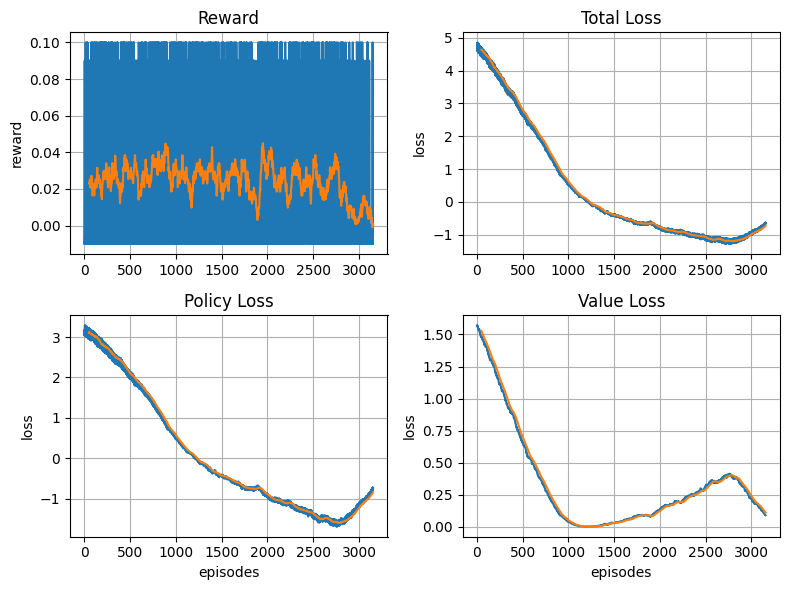


Actions Taken:
- DOWN: 1072
- EAST: 1061
- NORTH: 1095
- EAT: 1058
- SOUTH: 962
- WEST: 975

Messages Received:
- Hello Agent, welcome to NetHack!  You are a neutral human Caveman.: 2
- You cant go down here.: 1072
- Its solid stone.: 1995
- : 1956
- You dont have anything to eat.: 1058
- You are beginning to feel hungry.: 2
- You are beginning to feel weak.: 2
- You faint from lack of food.  You regain consciousness.: 88
- You can hear again.: 26
- You regain consciousness.: 22


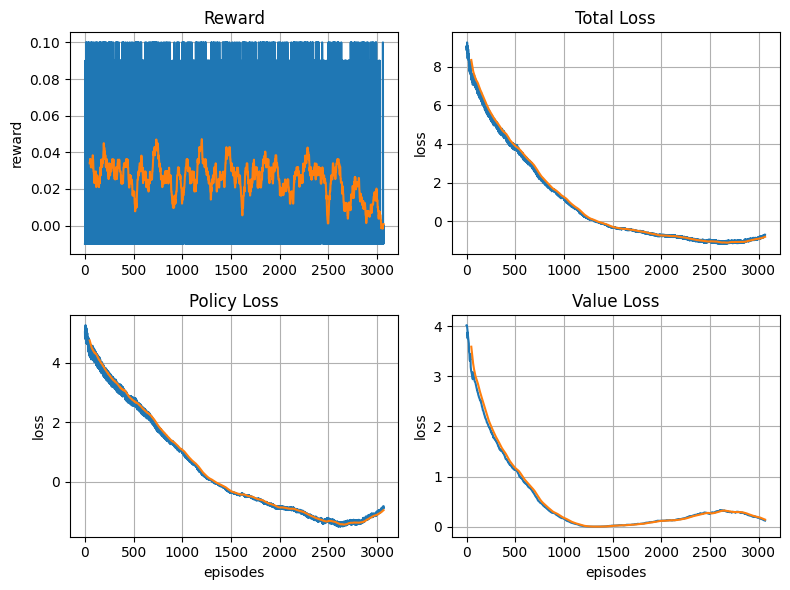


Actions Taken:
- DOWN: 1602
- EAST: 1662
- NORTH: 1668
- EAT: 1579
- SOUTH: 1448
- WEST: 1448

Messages Received:
- Hello Agent, welcome to NetHack!  You are a neutral human Caveman.: 3
- You cant go down here.: 1602
- Its solid stone.: 3062
- : 2928
- You dont have anything to eat.: 1579
- You are beginning to feel hungry.: 3
- You are beginning to feel weak.: 3
- You faint from lack of food.  You regain consciousness.: 134
- You can hear again.: 36
- You regain consciousness.: 32
- Its a wall.: 24
- You see here an iron wand.  You can hear again.: 1


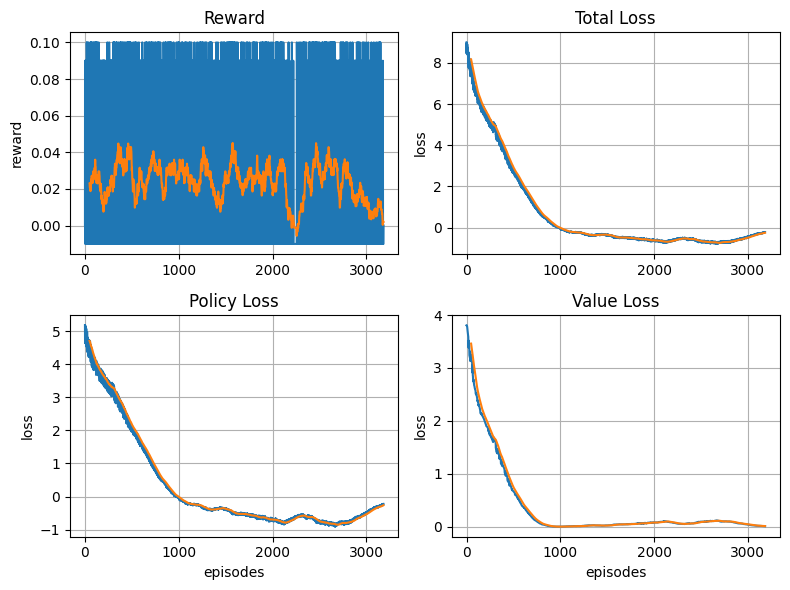

KeyboardInterrupt: 

In [79]:

# training
previous_description = ''
messages_received = dict()
actions_taken = dict()

for k in range(num_episodes):

    #visit_counts = dict()
    #coord_rewards = dict()

    obs = env.reset()
    
    done = False
    Actions, States, Rewards = [], [], []

    for h in range(max_steps):

        message = obs['message']
        msg = bytes(message)
        msg = str(msg).replace("'", "").replace('"', '').lstrip("b").rstrip("\\x00").rstrip("\x00")

        if msg not in messages_received:
            messages_received[msg] = 1
        else:
            messages_received[msg] += 1

        if verbose:
            print(msg[: msg.index(b"\0")])

        obs = convert_observation(obs)

        probs = nn.policy_net(obs)
        dist = torch.distributions.Categorical(probs = probs)
        action = dist.sample().item()

        # probs = nn(obs)
        # #dist = probs.detach().numpy()
        # #print(dist)
        # # if 0.1 > np.random.uniform():
        # #     action = np.random.choice([*range(env.action_space.n)])
        # # else:
        # dist = torch.distributions.Categorical(probs=probs)        
        # action = dist.sample().item()

        obs_, rew, done, _ = env.step(action)

        stats = obs_['blstats']
        coords = (stats[0], stats[1])

        # for i in range(-1, 2):
        #     for j in range(-1, 2):
        #         d = env.unwrapped.get_screen_description(coords[0] + i, coords[1] + j)
        #         if d != 'corridor': print( f", {d}")

        if action_text[action] not in actions_taken:
            actions_taken[action_text[action]] = 1
        else:
            actions_taken[action_text[action]] += 1

        if verbose:
            print( f"\rEpisode: {k+1}, Step: {h+1}, Coords: {coords}, Reward: {rew:0.4f}, Action: {action_text[action]}          ", end="")
        
        #rew = rew + get_exploration_reward(obs_, rew)
        
        env.render()

        Actions.append(torch.tensor(action, dtype=torch.int))
        States.append(obs)
        Rewards.append(rew)

        # move to the next state
        obs = obs_

        if done:
            break
        
    # DiscountedReturns = []
    # for t in range(len(Rewards)):
    #     G = 0.0
    #     for i, r in enumerate(Rewards[t:]):
    #         G += (gamma**i)*r
    #     DiscountedReturns.append(G)

    DiscountedReturns = []
    r = 0
    # discount over the trajectory
    for step in reversed(range(len(Rewards))):
        r = Rewards[step] + gamma * r
        DiscountedReturns.insert(0, r)

    # normalize the returns?
    # ensure type 
    DiscountedReturns = np.array(DiscountedReturns)

    # calculate the mean and std
    mean = DiscountedReturns.mean(axis = 0)
    std = DiscountedReturns.std(axis = 0)

    # average and normalize the returns
    if std != 0.0:
        DiscountedReturns = (DiscountedReturns - mean) / std

    PolicyLoss = []
    ValueLoss = []
    TotalLoss = []
    
    for State, Action, G in zip(States, Actions, DiscountedReturns):

        value = nn.value_net(State)

        delta = G - value

        probs = nn.policy_net(State)
        policy_dist = torch.distributions.Categorical(probs = probs)
        log_probs = policy_dist.log_prob(Action)

        policy_loss = -( delta.detach() * log_probs )
        nn.policy_optimizer.zero_grad()
        policy_loss.backward()
        nn.policy_optimizer.step()

        pl = policy_loss.detach().numpy()
        PolicyLoss.append(pl)

        value_loss = torch.sum(delta**2) / 2
        nn.value_optimizer.zero_grad()
        value_loss.backward()
        nn.value_optimizer.step()

        vl = value_loss.detach().numpy()
        ValueLoss.append(vl)
        
        # probs = nn(State)
        # dist = torch.distributions.Categorical(probs=probs)    
        # log_prob = dist.log_prob(Action)
        
        # loss = -(log_prob*G)
        total_loss = pl + vl
        TotalLoss.append(total_loss)
        
        # optim.zero_grad()
        # loss.backward()
        # optim.step()

    if verbose:
        print( f"""
            Tot. Rewards: {np.sum(Rewards):0.4f}, Avg. Reward: {np.mean(Rewards):0.4f}, 
            Tot. Loss: {np.sum(TotalLoss):0.4f}, Avg Loss: {np.mean(TotalLoss):0.4f},
            Tot. Policy Loss: {np.sum(PolicyLoss):0.4f}, Avg Policy Loss: {np.mean(PolicyLoss):0.4f},
            Tot. Value Loss: {np.sum(ValueLoss):0.4f}, Avg Value Loss: {np.mean(ValueLoss):0.4f}
            """)

    print("\nActions Taken:")
    for key, val in actions_taken.items():
        print(f"- {key}: {val}")

    print("\nMessages Received:")
    for key, val in messages_received.items():
        print(f"- {key}: {val}")

    if intermediate_plots:

        PolicyLoss = np.reshape(PolicyLoss, (np.shape(PolicyLoss)[0], 1))
        ValueLoss = np.reshape(ValueLoss, (np.shape(ValueLoss)[0], 1))
        TotalLoss = np.reshape(TotalLoss, (np.shape(ValueLoss)[0], 1))

        #Plot stuff
        window = int(max_steps * 0.01)
        fig, axs = plt.subplots(2, 2)
        fig.set_figheight(6)
        fig.set_figwidth(8)

        #axs[0].plot(pd.DataFrame(Rewards))

        axs[0][0].title.set_text('Reward')
        #axs[0][0].set_xlabel('episodes')
        axs[0][0].set_ylabel('reward')
        axs[0][0].plot(pd.DataFrame(Rewards))
        axs[0][0].plot(pd.DataFrame(Rewards).rolling(window).mean())
        axs[0][0].grid(True)

        axs[0][1].title.set_text('Total Loss')
        #axs[0][1].set_xlabel('episodes')
        axs[0][1].set_ylabel('loss')
        axs[0][1].plot(pd.DataFrame(TotalLoss))
        axs[0][1].plot(pd.DataFrame(TotalLoss).rolling(window).mean())
        axs[0][1].grid(True)

        axs[1][0].title.set_text('Policy Loss')
        axs[1][0].set_xlabel('episodes')
        axs[1][0].set_ylabel('loss')
        axs[1][0].plot(pd.DataFrame(PolicyLoss))
        axs[1][0].plot(pd.DataFrame(PolicyLoss).rolling(window).mean())
        axs[1][0].grid(True)

        axs[1][1].title.set_text('Value Loss')
        axs[1][1].set_xlabel('episodes')
        axs[1][1].set_ylabel('loss')
        axs[1][1].plot(pd.DataFrame(ValueLoss))
        axs[1][1].plot(pd.DataFrame(ValueLoss).rolling(window).mean())
        axs[1][1].grid(True)

        fig.tight_layout()

        plt.show()

    
    